# Exercise: PPG SNR

A useful task for evaluating PPG signals is computing the signal-to-noise ratio (SNR). The SNR of a signal is a measure of how noisy the signal. High SNRs mean that the signal has very little noise. Often times, calculating the SNR is more of an art than a science because most often, we don't know what parts of the signal is noise and what is not.

When you have a PPG signal with a contemporaneous reference pulse rate, you can use that pulse rate to approximate the SNR of the PPG signal. Ideally, most of the energy in the Fourier transform of the signal should be concentrated around the pulse rate frequency (and any harmonics of that frequency). So one measure of SNR would be the ratio of energy around the pulse rate frequency (and harmonics) to the amount of energy elsewhere.

This exercise will guide you through this process for three different signals.

## Imports

In [30]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
from helpers import get_topK_amp_freq
import scipy as sp
import scipy.signal
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

You are given 3 different signals along with the average heart rate for that signal in beats per minute (BPM).

In [2]:
fs = 125
with np.load('./exercise3.npz') as npz:
    sig0 = npz['sig0']
    hr0_bpm = npz['hr0_bpm']
    sig1 = npz['sig1']
    hr1_bpm = npz['hr1_bpm']
    sig2 = npz['sig2']
    hr2_bpm = npz['hr2_bpm']

## Data Exploration

Use this space to explore your data. Plot your signals and the Fourier transforms. Think about which signals have a higher SNR and what you notice about their FFTs.

In [3]:
time = np.array(range(len(sig0)))/fs

### signal visualization

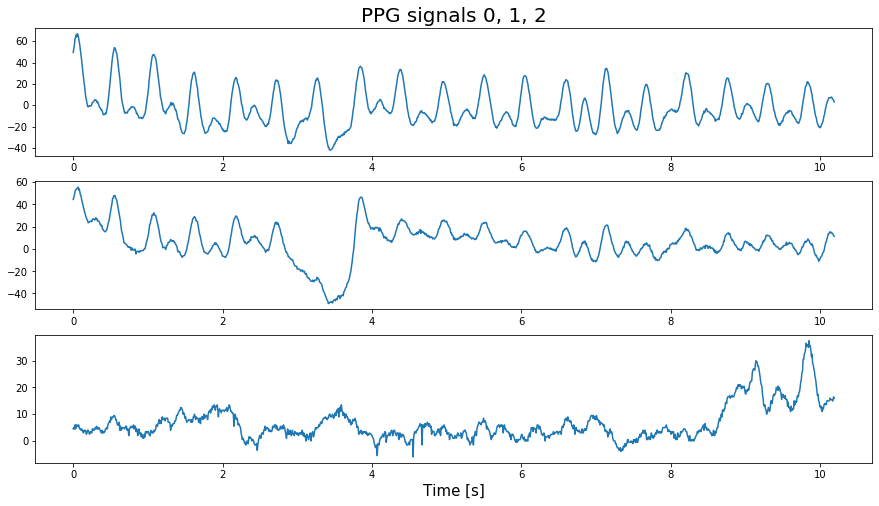

In [4]:
plt.figure(figsize=(15,8))
plt.subplot(311)
plt.plot(time, sig0)
plt.title('PPG signals 0, 1, 2', fontsize=20)
plt.subplot(312)
plt.plot(time, sig1)
plt.subplot(313)
plt.plot(time, sig2)
plt.xlabel('Time [s]', fontsize=15);

### Spectrogram for each signal
#### Signal 0

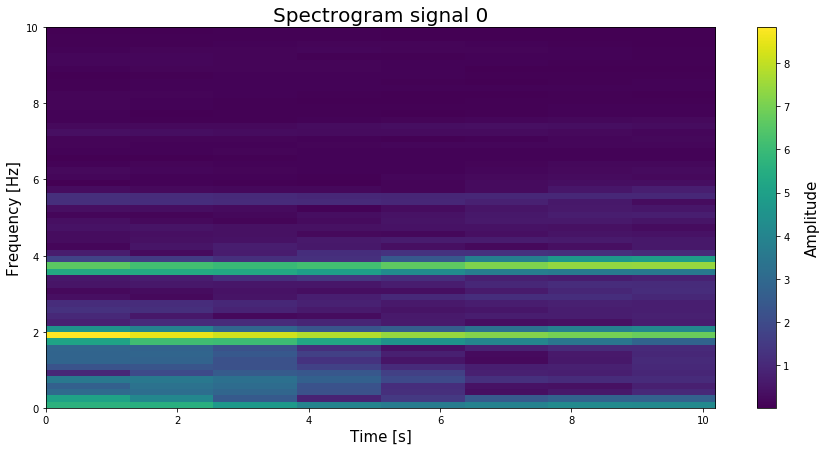

 Top frequencies presented:[1.83333333 3.66666667]


In [5]:
plt.figure(figsize=(15,7))
NFFT=fs*6
spec, freqs, t, cax = plt.specgram(sig0, Fs=fs, NFFT=NFFT, noverlap=NFFT*0.9, scale='linear', mode='magnitude',
                                  xextent=(0,time[-1]))
plt.ylim(0,10)
cbar = plt.colorbar();
cbar.ax.set_ylabel('Amplitude', rotation=90, labelpad=15, fontsize=15)
plt.xlabel('Time [s]', fontsize=15);
plt.title('Spectrogram signal 0',fontsize=20)
plt.ylabel('Frequency [Hz]', fontsize=15);
topFreqs=np.unique(freqs[np.argmax(spec, axis=0)])
plt.show()
print(f" Top frequencies presented:{topFreqs}")

#### Signal 1

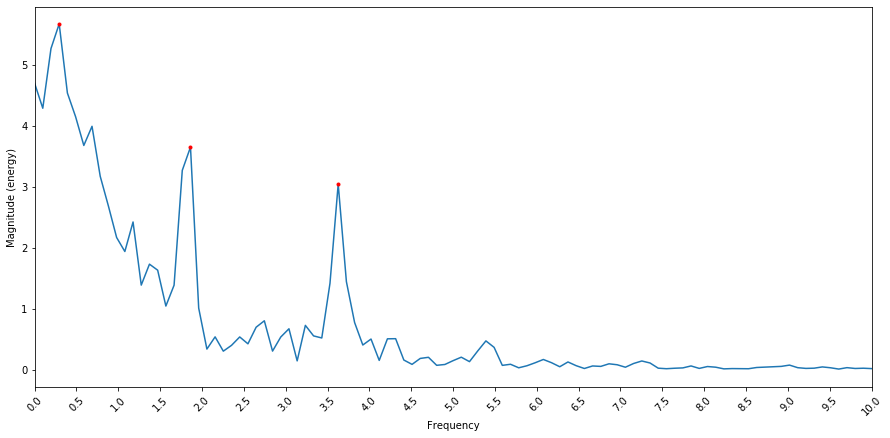

max frequencies are: [0.29411765 1.8627451  3.62745098]


In [45]:
plt.figure(figsize=(15,7))
ax=plt.subplot(111)
ampls, freqs, _ = plt.magnitude_spectrum(sig1, Fs=fs);
pks = sp.signal.find_peaks(ampls, prominence=1)[0]
plt.plot(freqs[pks], ampls[pks], 'r.');
plt.xlim(0, 10)
loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45); #this rotates the ticks
plt.show()
print(f"max frequencies are: {freqs[pks]}")

#### Signal 2

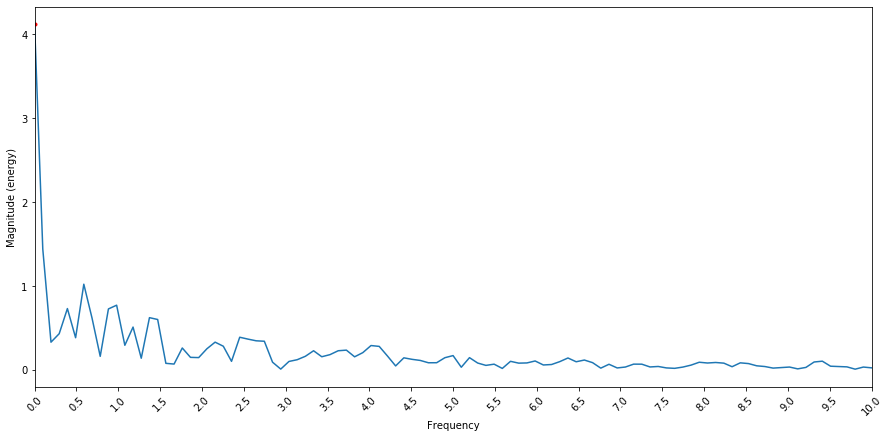

max frequencies are: 0.0


In [49]:
plt.figure(figsize=(15,7))
ax=plt.subplot(111)
ampls, freqs, _ = plt.magnitude_spectrum(sig2, Fs=fs);
pks = np.argmax(ampls)
plt.plot(freqs[pks], ampls[pks], 'r.');
plt.xlim(0, 10)
loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45); #this rotates the ticks
plt.show()
print(f"max frequencies are: {freqs[pks]}")

**Conclusion** We can tell that sig 0 is clear enough to extract its predominant frequencies. On the other hand, sig 1 is a little bit more challenging but it is still possible. Finally signal 2 is completely distorted and hence difficult to identify its frequencies.

## Calculate SNR Function

The SNR is the ratio of signal power to noise power. To calculate the signal power:
  - compute the FFT of the signal
  - calculating the signal power by:
    - summing the FFT magnitudes in a window of 5 BPM around the frequency of the average heart rate
    - and summing the FFT magnitudes in a window of 5 BPM around the first harmonic of the average heart rate
  - calculate the noise power by:
    - summing the FFT magnitudes everywhere else
  - divide the signal power by the noise power

In [60]:
def CalcSNR(sig, hr_bpm):
    # Our data is sampled at 125 Hz
    fs = 125
    # Convert heart rate to Hz
    hr_hz = hr_bpm/60;
    # 2nd Harmonic
    harmonic_2 = hr_hz*2;
    
    # Take the fft magnitudes of the signal
    freqs = np.fft.rfftfreq(len(sig),1./fs)
    fft_mag = np.abs(np.fft.rfft(sig))
    # Define windows
    window = 5/60 # in Hz
    window_fundamental_freq = (freqs>hr_hz-window) & (freqs<hr_hz+window)
    window_2nd_harmonic = (freqs>harmonic_2-window) & (freqs<harmonic_2+window)
    
    # Compute signal power and noise power
    signal_power = np.sum(fft_mag[window_fundamental_freq | window_2nd_harmonic])
    noise_power = np.sum(fft_mag[~(window_fundamental_freq | window_2nd_harmonic)])

    # Compute SNR
    snr = signal_power / noise_power
    return snr

## Compute SNR on our signals

Now run the CalcSNR function on our signals and see if they match up with the expected results.

In [61]:
snr0 = CalcSNR(sig0, hr0_bpm)
snr0

0.23841371451080368

In [66]:
snr1 = CalcSNR(sig1, hr1_bpm)
snr1

0.12383805520290737

In [63]:
snr2 = CalcSNR(sig2, hr2_bpm)
snr2

0.049378982420093684

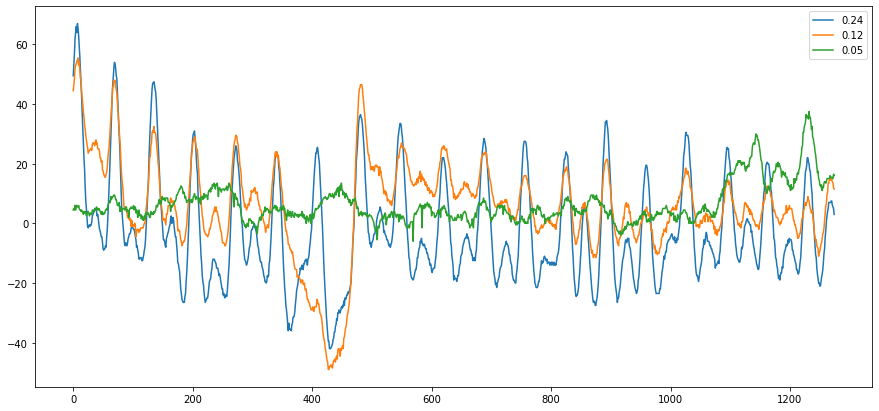

In [65]:
plt.figure(figsize=(15, 7))
plt.plot(sig0, label='{:0.2f}'.format(snr0)) 
plt.plot(sig1, label='{:0.2f}'.format(snr1))
plt.plot(sig2, label='{:0.2f}'.format(snr2))
plt.legend();

**Conslusion** In conclusion we can confirm what we already confirm in our analysis above. Signal 0 has the highest SNR meaning that is has the less noise of the 3 signals. Followed by signal 1. However, signal 2 has almost zero SNR which means that the signal is very noisy and hence almost impossible to get data from. 